# Converting the below mentioned research paper into code:
2020 International Conference on Industrial Engineering, Applications and Manufacturing (ICIEAM)
978-1-7281-4590-7/20/$31.00 ©2020 IEEE
# Facial Image Denoising Using Convolutional Autoencoder Network
Authors:\
Naing Min Tun\
Bauman Moscow State Technical University\
Moscow, Russia\
naingminhtun52@gmail.com\
Alexander I. Gavrilov\
Bauman Moscow State Technical University\
Moscow, Russia\
alexgavrilov@mail.ru\
Nyan Linn Tun\
Bauman Moscow State Technical University\
Moscow, Russia\
nyanlin54@gmail.com\

# Convolutional Autoencoder Network

Abstract—Noise effects can interfere the face recognition
process in outdoor conditions. Therefore, image denoising topic is
the classical issue in the field of image processing and computer
vision subjects. In this paper, we show that the solution of
denoising process using the autoencoder networks based on the
ORL face database. The proposed method can support face
recognition systems designed for use in an outdoor environment
as the preprocessing stage and it can provide the effective results
after training process

# Importing libraries

In [ ]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D


# Utility Functions

In [ ]:
def plot_autoencoder_outputs(autoencoder, n, dims):
    decoded_imgs = autoencoder.predict(x_test)

    # number of example digits to show
    n = 5
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx

    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))

    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")

    plt.xlim(0, min_epoch-1)
    plt.tight_layout()

In [ ]:
 !unzip ORL_Dataset.zip

Archive:  ORL_Dataset.zip
  inflating: 100_10.jpg              
  inflating: 101_11.jpg              
  inflating: 102_11.jpg              
  inflating: 103_11.jpg              
  inflating: 104_11.jpg              
  inflating: 105_11.jpg              
  inflating: 106_11.jpg              
  inflating: 107_11.jpg              
  inflating: 108_11.jpg              
  inflating: 109_11.jpg              
  inflating: 10_1.jpg                
  inflating: 110_11.jpg              
  inflating: 111_12.jpg              
  inflating: 112_12.jpg              
  inflating: 113_12.jpg              
  inflating: 114_12.jpg              
  inflating: 115_12.jpg              
  inflating: 116_12.jpg              
  inflating: 117_12.jpg              
  inflating: 118_12.jpg              
  inflating: 119_12.jpg              
  inflating: 11_2.jpg                
  inflating: 120_12.jpg              
  inflating: 121_13.jpg              
  inflating: 122_13.jpg              
  inflating: 123_13.jpg 

(80, 70)


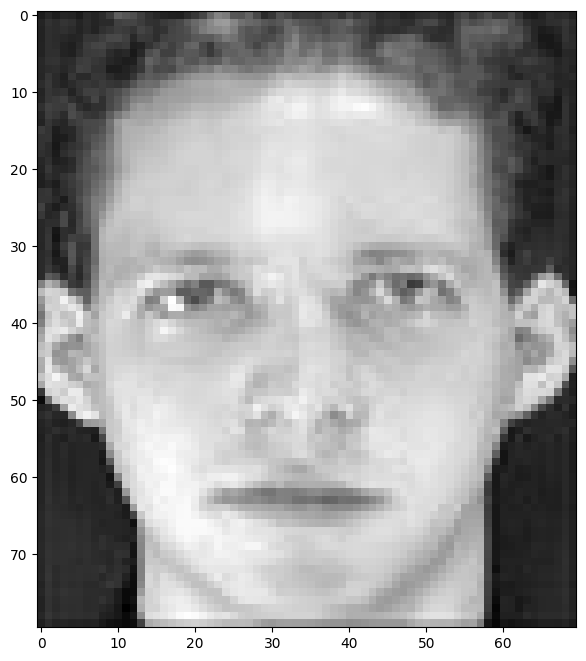

In [ ]:
plt.figure(figsize=(20,8))
img = cv2.imread('/content/1_1.jpg', 0)
plt.imshow(img, cmap='gray')
print(img.shape)

Cleaning image filenames

In [ ]:
# import os

# # Specify the directory where your images are located
# directory_path = "/content"
# os.chdir(directory_path)

# # List all the files in the directory
# files = os.listdir()

# # Iterate through the files, rename them by removing the underscore and the following number
# for filename in files:
#     new_filename = filename.split('_')[0]  # Split by underscore and keep the first part
#     os.rename(filename, new_filename)


In [ ]:
import cv2
import numpy as np
import os

# Specify the directory where your original images are located (in Google Colab, it's the "content" directory)
input_directory = "/content"

# Create an empty list to store the image data as numpy arrays
image_data = []

# Iterate through the images in the input directory
for filename in os.listdir(input_directory):
    if filename.endswith(('.jpg')):  # You can specify the image file extensions you want to include
        input_path = os.path.join(input_directory, filename)

        # Read the image
        img = cv2.imread(input_path)

        if img is not None:
            # Resize the image to 128x128 pixels
            img_resized = cv2.resize(img, (128, 128))

            # Convert the resized image to a numpy array
            img_array = np.array(img_resized)

            # Append the numpy array to the list
            image_data.append(img_array)
        else:
            print(f"Skipping {filename} as it couldn't be read.")

# Now, 'image_data' contains a list of numpy arrays representing your resized images.


In [ ]:
image_data

In [ ]:
# Assuming you have 'image_data' containing your numpy arrays

# Shuffle the data randomly
np.random.shuffle(image_data)

# Calculate the split point based on the desired ratio (75% training, 25% testing)
split_ratio = 0.75
split_index = int(len(image_data) * split_ratio)

# Split the data into training and testing sets
training_data = image_data[:split_index]
testing_data = image_data[split_index:]

# Now, 'training_data' contains 75% of your images, and 'testing_data' contains 25%.


In [ ]:
training_data

In [ ]:
# approach 2
# Function to add noise to a single image
def add_noise_to_image(image, noise_std):
    # # Convert the image to grayscale if it's not already
    # if len(image.shape) == 3 and image.shape[2] == 3:
    #     img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # else:
    img_gray = image

    # Generate noise with the same shape as the image
    noise = np.random.normal(0, noise_std, img_gray.shape)

    # Add the noise to the image
    img_noised = img_gray + noise

    # Clip the pixel values to be between 0 and 255
    img_noised = np.clip(img_noised, 0, 255).astype(np.uint8)

    return img_noised

# Add noise to the training data
noise_std = 50  # Adjust the noise standard deviation as needed
noisy_training_data = [add_noise_to_image(image, noise_std) for image in training_data]

# Add noise to the testing data
noisy_testing_data = [add_noise_to_image(image, noise_std) for image in testing_data]


In [ ]:
noisy_training_data

In [ ]:
# Clip the pixel values to be between 0 and 1
noisy_training_data = [np.clip(image / 255.0, 0, 1) for image in noisy_training_data]
noisy_testing_data = [np.clip(image / 255.0, 0, 1) for image in noisy_testing_data]

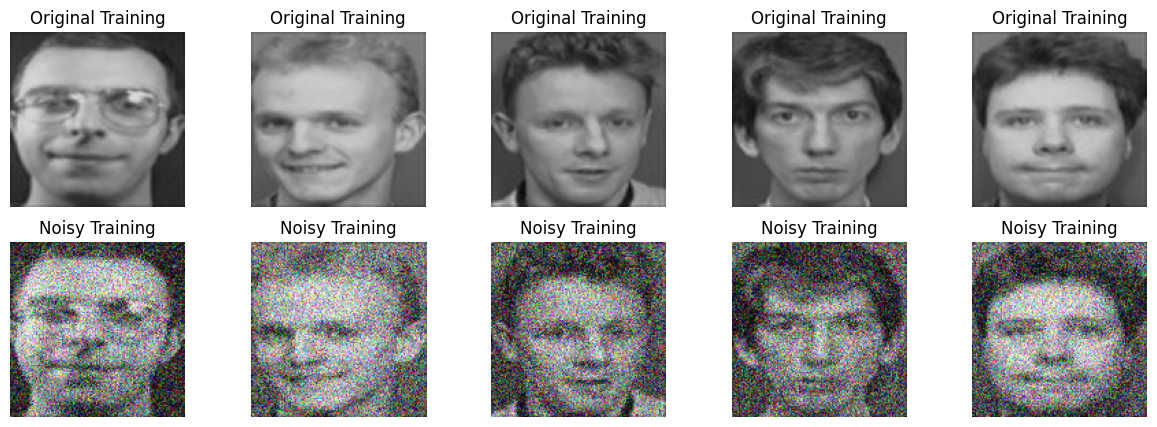

In [ ]:
# Assuming you have 'training_data' and 'noisy_training_data'
# as well as 'testing_data' and 'noisy_testing_data' as described earlier

# Function to display images before and after adding noise
def visualize_images(original, noisy, title_original, title_noisy):
    num_samples = len(original)

    # Randomly select and display a subset of images
    num_samples_to_display = 5
    indices_to_display = np.random.choice(num_samples, num_samples_to_display, replace=False)

    plt.figure(figsize=(15, 5))

    for i, idx in enumerate(indices_to_display):
        plt.subplot(2, num_samples_to_display, i + 1)
        plt.imshow(original[idx], cmap='gray')
        plt.title(title_original)
        plt.axis('off')

        plt.subplot(2, num_samples_to_display, num_samples_to_display + i + 1)
        plt.imshow(noisy[idx], cmap='gray')
        plt.title(title_noisy)
        plt.axis('off')

    plt.show()

# Visualize training data before and after adding noise
visualize_images(training_data, noisy_training_data, "Original Training", "Noisy Training")


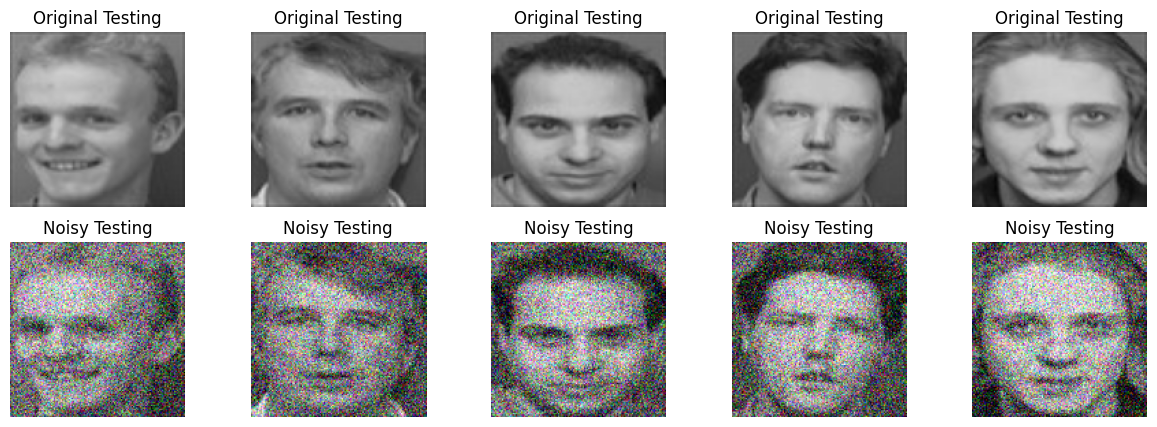

In [ ]:
# Visualize testing data before and after adding noise
visualize_images(testing_data, noisy_testing_data, "Original Testing", "Noisy Testing")


In [ ]:
pip install tensorflow


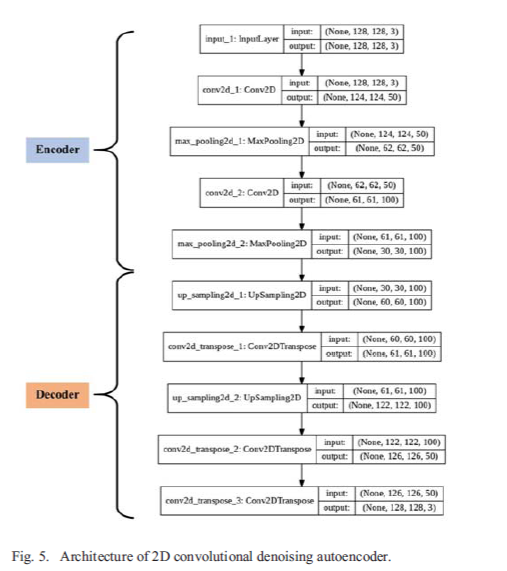

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model
import keras
# noisy_training_data = np.expand_dims(noisy_training_data, axis=-1)
# noisy_testing_data = np.expand_dims(noisy_testing_data, axis=-1)
# Define the input layer
input_layer = Input(shape=(128, 128, 3))

# Encoder
encoder_conv1 = Conv2D(50, (5, 5), activation='relu', padding='same')(input_layer)
encoder_pool1 = MaxPooling2D((2, 2))(encoder_conv1)
encoder_conv2 = Conv2D(100, (2, 2), activation='relu', padding='same')(encoder_pool1)
encoder_pool2 = MaxPooling2D((2, 2))(encoder_conv2)

# Decoder
decoder_upsample1 = UpSampling2D((2, 2))(encoder_pool2)
decoder_conv1 = Conv2DTranspose(100, (2, 2), activation='relu', padding='same')(decoder_upsample1)
decoder_upsample2 = UpSampling2D((2, 2))(decoder_conv1)
decoder_conv2 = Conv2DTranspose(50, (5, 5), activation='relu', padding='same')(decoder_upsample2)
decoder_conv3 = Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(decoder_conv2)

# Create the autoencoder model
autoencoder = Model(input_layer, decoder_conv3)
optimizer = Adam(learning_rate=0.001)
# Compile the model (you can adjust the optimizer and loss function as needed)
autoencoder.compile(optimizer=optimizer, loss=keras.losses.mean_absolute_error)

# Print a summary of the model architecture
autoencoder.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_33 (Conv2D)          (None, 128, 128, 50)      3800      
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 64, 64, 50)        0         
 ng2D)                                                           
                                                                 
 conv2d_34 (Conv2D)          (None, 64, 64, 100)       20100     
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 32, 32, 100)       0         
 ng2D)                                                           
                                                                 
 up_sampling2d_30 (UpSampli  (None, 64, 64, 100)       0  

In [ ]:
# Train the autoencoder for 100 epochs
epochs = 10

# Convert the training data to NumPy arrays if they are not already
noisy_training_data = np.array(noisy_training_data)
training_data = np.array(training_data)
# noisy_training_data = noisy_training_data.reshape(-1, 128, 128, 1)
# training_data = training_data.reshape(-1, 128, 128, 1)
# Train the model
history = autoencoder.fit(noisy_training_data, training_data,
                          epochs=epochs,
                          batch_size=32,  # Adjust batch size as needed
                          shuffle=True,   # Shuffle the training data
                          validation_split=0.2)

Epoch 1/10
8/8 [==============================] - 3s 143ms/step - loss: 111.3034 - val_loss: 113.2363
Epoch 2/10
8/8 [==============================] - 1s 108ms/step - loss: 111.1320 - val_loss: 113.2362
Epoch 3/10
8/8 [==============================] - 1s 109ms/step - loss: 111.1320 - val_loss: 113.2362
Epoch 4/10
8/8 [==============================] - 1s 119ms/step - loss: 111.1319 - val_loss: 113.2362
Epoch 5/10
8/8 [==============================] - 1s 108ms/step - loss: 111.1319 - val_loss: 113.2362
Epoch 6/10
8/8 [==============================] - 1s 108ms/step - loss: 111.1320 - val_loss: 113.2362
Epoch 7/10
8/8 [==============================] - 1s 120ms/step - loss: 111.1319 - val_loss: 113.2362
Epoch 8/10
8/8 [==============================] - 1s 121ms/step - loss: 111.1320 - val_loss: 113.2362
Epoch 9/10
8/8 [==============================] - 1s 125ms/step - loss: 111.1319 - val_loss: 113.2362
Epoch 10/10
8/8 [==============================] - 1s 120ms/step - loss: 111.1319 

In [ ]:
# Extract loss values from the history object
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Create a range of epoch numbers
epochs = range(1, len(training_loss) + 1)

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

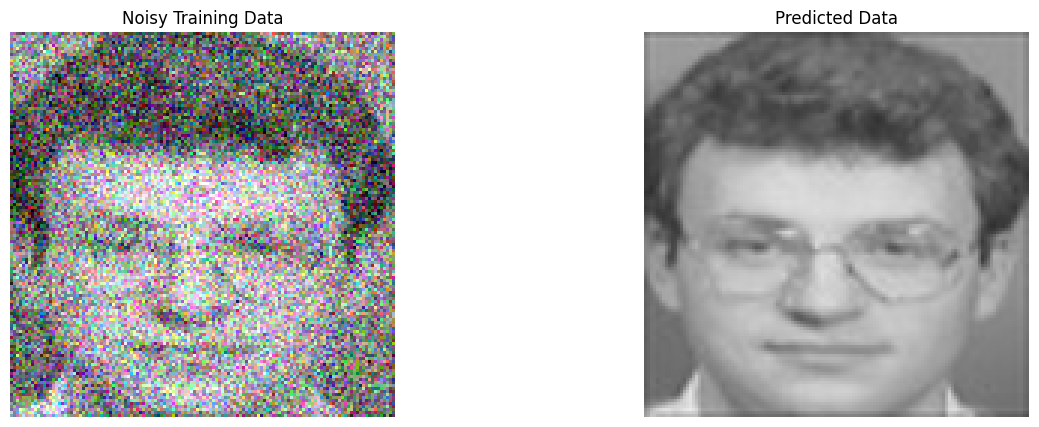

In [ ]:
# Assuming 'noisy_training_data' and 'predictions' are NumPy arrays with image data

# Function to display a list of images
def display_images(images, titles):
    num_images = len(images)
    plt.figure(figsize=(15, 5))

    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')

    plt.show()

# Display noisy training data and predictions
display_images([noisy_training_data[0], training_data[0]], ['Noisy Training Data', 'Predicted Data'])


In [ ]:

# Function to add Gaussian noise to images
def add_gaussian_noise(images, std_dev):
    noise = np.random.normal(0, std_dev, images.shape)
    noisy_images = np.clip(images + noise, 0, 1)
    return noisy_images

# Function to add Salt and Pepper noise to images
def add_salt_and_pepper_noise(images, salt_prob, pepper_prob):
    noisy_images = np.copy(images)
    salt_mask = np.random.rand(*images.shape[:-1]) < salt_prob
    pepper_mask = np.random.rand(*images.shape[:-1]) < pepper_prob
    noisy_images[salt_mask] = 1.0
    noisy_images[pepper_mask] = 0.0
    return noisy_images

# Function to add Poisson noise to images
def add_poisson_noise(images):
    noisy_images = np.random.poisson(images * 255) / 255.0
    return np.clip(noisy_images, 0, 1)

# Load your clean images (original dataset)
clean_images =  np.array(clean_images)

# Define hyperparameters
num_epochs = 10
batch_size = 32

# Experiment 1: Gaussian Noise
std_dev = 0.1  # Standard deviation of Gaussian noise
noisy_images_gaussian = add_gaussian_noise(clean_images, std_dev)

# Train the autoencoder with Gaussian noise
autoencoder.fit(noisy_images_gaussian, clean_images, epochs=num_epochs, batch_size=batch_size)

# Experiment 2: Salt and Pepper Noise
salt_prob = 0.02  # Probability of adding salt noise
pepper_prob = 0.02  # Probability of adding pepper noise
noisy_images_sp = add_salt_and_pepper_noise(clean_images, salt_prob, pepper_prob)

# Train the autoencoder with Salt and Pepper noise
autoencoder.fit(noisy_images_sp, clean_images, epochs=num_epochs, batch_size=batch_size)

# Experiment 3: Poisson Noise
noisy_images_poisson = add_poisson_noise(clean_images)

# Train the autoencoder with Poisson noise
autoencoder.fit(noisy_images_poisson, clean_images, epochs=num_epochs, batch_size=batch_size)


Epoch 1/10
13/13 [==============================] - 4s 359ms/step - loss: 111.5977
Epoch 2/10
13/13 [==============================] - 1s 98ms/step - loss: 111.5977
Epoch 3/10
13/13 [==============================] - 1s 97ms/step - loss: 111.5977
Epoch 4/10
13/13 [==============================] - 1s 99ms/step - loss: 111.5977
Epoch 5/10
13/13 [==============================] - 1s 101ms/step - loss: 111.5977
Epoch 6/10
13/13 [==============================] - 1s 98ms/step - loss: 111.5977
Epoch 7/10
13/13 [==============================] - 1s 98ms/step - loss: 111.5977
Epoch 8/10
13/13 [==============================] - 1s 98ms/step - loss: 111.5977
Epoch 9/10
13/13 [==============================] - 1s 99ms/step - loss: 111.5977
Epoch 10/10
13/13 [==============================] - 1s 98ms/step - loss: 111.5977
Epoch 1/10
13/13 [==============================] - 2s 98ms/step - loss: 111.5977
Epoch 2/10
13/13 [==============================] - 1s 97ms/step - loss: 111.5977
Epoch 3/10
13